# Analyzing NYC High School Data

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups.

For this project we will be investigating the correlations between SAT scores and demographics. We could correlate SAT scores with factors like race, gender, income, and more.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's important to perform well.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the dataset for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

## Step 1: Initial Exploration and Cleaning of Data

### Finding Relavant Datasets

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) available online, as well as the [demographics for each high school](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2).

Unfortunately, combining both of the datasets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do our full analysis.

The same website has several related datasets covering demographic information and test scores. Here are the links to all of the datasets we'll be using:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

All of these datasets are interrelated. We'll combine them into a single dataset before we can find correlations.

### Finding Background Information

We'll research:

- [New York City](https://en.wikipedia.org/wiki/New_York_City)
- [The SAT](https://en.wikipedia.org/wiki/SAT)
- [Schools in New York City](https://en.wikipedia.org/wiki/List_of_high_schools_in_New_York_City)
- [Our data](https://data.cityofnewyork.us/browse?category=Education)

We can learn a few different things from these resources. For example:

- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contain dozens of schools.
- Our datasets include several different types of schools. We'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a DBN or district borough number.
- Aggregating data by district allows us to use the district mapping data to plot district-by-district differences.

### Reading in the data

In [301]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Exploring the SAT data

We're mainly interested in the SAT dataset, which corresponds to the dictionary key sat_results. This dataset contains the SAT scores for each high school in New York City.

Let's explore sat_results to see what we can discover.

In [302]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can make a few observations based on this output:

- The DBN appears to be a unique ID for each school.
- We can tell from the first few rows of names that we only have data about high schools.
- There's only a single row for each high school, so each DBN is unique in the SAT data.
- We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.

### Exploring the remaining data

In [303]:
for key in data:
    print(data[key].head(), '\n')

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s   

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2   

We can make some observations based on the first few rows of each one.

- Each dataset appears to either have a DBN column or the information we need to create one. That means we can use a DBN column to combine the datasets. First we'll pinpoint matching rows from different datasets by looking for identical DBNs, then group all of their columns together in a single dataset.
- Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string.
- Some of the datasets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each dataset. If we don't do this, we'll run into problems when we combine the datasets, because we might be merging two rows in one data set with one row in another dataset.

### Reading in the Survey Data

The survey files survey_all.txt and survey_d75.txt are tab delimited and encoded with "Windows-1252" encoding.

In [304]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

There are two immediate facts that we can see in the data:

- There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns makes it easier to print the dataframe out and find correlations within it.
- The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion makes the column name consistent with the other data sets.

### Cleaning up the Surveys

First we must filter the columns to remove the ones we don't need. We can use the data dictionary available at the [original download location](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) to determine which columns to use.

Before we filter columns out, we will copy the data from dbn to a new column DBN.

In [305]:
survey["DBN"] = survey["dbn"]
survey_fields = ['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']
survey = survey[survey_fields]
data["survey"] = survey

When we explored all of the datasets, we noticed that some of them, like class_size and hs_directory, don't have a DBN column. hs_directory does have a dbn column, though, so we can just rename it.

However, class_size doesn't appear to have the column at all. Here are the first few rows of the data set:

In [306]:
print(data['class_size'].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


Here are the first few rows of the sat_results data, which does have a DBN column:

In [307]:
print(data['sat_results'].head())

      DBN                                    SCHOOL NAME  \
0  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1  01M448            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2  01M450                     EAST SIDE COMMUNITY SCHOOL   
3  01M458                      FORSYTH SATELLITE ACADEMY   
4  01M509                        MARTA VALLE HIGH SCHOOL   

  Num of SAT Test Takers SAT Critical Reading Avg. Score SAT Math Avg. Score  \
0                     29                             355                 404   
1                     91                             383                 423   
2                     70                             377                 402   
3                      7                             414                 401   
4                     44                             390                 433   

  SAT Writing Avg. Score  
0                    363  
1                    366  
2                    370  
3                    359  
4                    38

From looking at these rows, we can tell that the DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded, so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

### Adding DBN columns

In [308]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Combining the SAT scores

We create a new column that totals up the SAT scores for the different sections of the exam. This will make it easier to correlate scores with demographic factors because we will be working with a single number, rather than 3 different ones.

Before we can generate this column, we'll need to convert the SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score columns in the sat_results dataset from the object (string) data type to a numeric data type.

In [309]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

### Parsing Geographic Coordinates for Schools

This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field Location 1 in the hs_directory dataset.

Let's take a look at the first few rows:

In [310]:
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

We can observe that this field contains a lot of information we do not need. We want to extract the coordinates present in the parenthesis at the end of the field.

In [311]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Step 2: Combining the Data

In Step 1, we manipulated the datasets, and found the we could combine them all using the DBN column. In this step, we will clean the data a bit more and then combine it.

The first thing we'll need to do in preparation for the merge is condense some of the datasets. In the previous step, we noticed that the values in the DBN column were unique in the sat_results data set. Other data sets like class_size had duplicate DBN values. We'll need to condense these datasets so that each value in the DBN column is unique. If not, we'll run into issues when it comes time to combine the datasets.

While the main dataset we want to analyze, sat_results, has unique DBN values for every high school in New York City, other datasets aren't as clean. A single row in the sat_results dataset may match multiple rows in the class_size dataset, for example. This situation creates problems, because we don't know which of the multiple entries in the class_size dataset we should combine with the single matching entry in sat_results.

To resolve this issue, we'll condense the class_size, graduation and demographics datasets so that each DBN is unique.

### Condensing the Class Size Data Set

The first few rows of class_size look like this:

In [312]:
class_size = data["class_size"]
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


We observe that the first few rows all pertain to the same school which is why the DBN appears more than once. It appears that each school has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12 ONLY).

If we look at the unique values for GRADE and PROGRAM TYPE, we get the following:

In [313]:
print(class_size['GRADE '].value_counts(),'\n')
print(class_size['PROGRAM TYPE'].value_counts(),'\n')

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64 

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64 



Since we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.
Each school can have multiple program types. Since GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.

In [314]:
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

We see that DBN is still not unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns.

We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average.

In [315]:
import numpy as np
class_size = class_size.groupby('DBN').agg(np.mean).reset_index()
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Condensing the Demographics Data Set

Here are the first few rows:

In [316]:
demographics = data['demographics']
demographics.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data (according to our data set), and also match our SAT results data.

In [317]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

### Condensing the Graduation Data Set

Here are the first few rows:

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [318]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP Test Scores to Numeric

The last thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are rarer in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

We need to convert three columns:

- AP Test Takers
- Total Exams Taken
- Number of Exams with scores 3, 4 or 5

In [319]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

Since this project is concerned with determining demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from sat_results while minimizing null values.

- Some of the datasets have a lot of missing DBN values. This makes a left join more appropriate, because we don't want to lose too many rows when we merge.
- Some datasets have DBN values that are almost identical to those in sat_results. Those datasets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from demographics, for example. Therefore, we'll do an inner join to avoid missing data in these columns.

In [320]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

We notice that the inner joins resulted in 116 fewer rows in sat_results. This is because pandas couldn't find the DBN values that existed in sat_results in the other datasets. While this is worth investigating, we're currently looking for high-level correlations, so we don't need to dive into which DBNs are missing.

We also notice that we now have many columns with null (NaN) values. This is because we chose to do left joins, where some columns may not have had data. The dataset also had some missing values to begin with. If we hadn't performed a left join, all of the rows with missing data would have been lost in the merge process, which wouldn't have left us with many high schools in our data set.

### Filling in Missing Values

In [321]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Add a school district column for mapping

We've finished cleaning and combining our data! We now have a clean dataset we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the dataset that specifies the school district helps us accomplish this.

The school district is just the first two characters of the DBN. We can apply a function over the DBN column of combined that pulls out the first two letters.

In [322]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Step 3: Analyzing and Visualizing the Data

In this step, we will discover correlations, create plots, and then make maps.

In [323]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64

Unsurprisingly, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score are strongly correlated with sat_score.

We can also make some other observations:

- total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
    - Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.
- Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.
- Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.
- Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
- There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
- The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.

Since enrollment seems to have such a strong correlation, let's make a scatterplot of total_enrollment vs sat_score. Each point in the scatterplot represents a high school, so we'll be able to see if there are any interesting patterns.

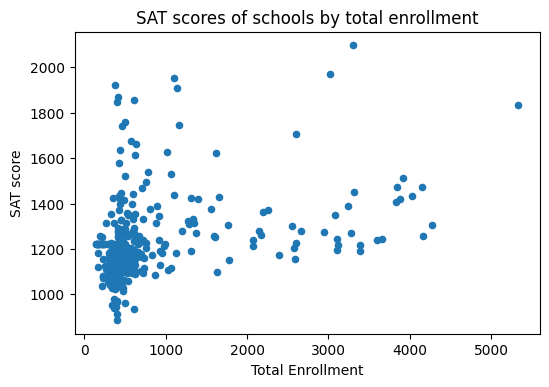

In [324]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = combined.plot.scatter(x='total_enrollment', y='sat_score')
ax.set_xlabel('Total Enrollment')
ax.set_ylabel('SAT score')
ax.set_title('SAT scores of schools by total enrollment')
plt.show()

Judging from the plot we just created, it doesn't appear there's a strong correlation between sat_score and total_enrollment. If there was a strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [325]:
low_enrollment = combined.loc[combined['total_enrollment'] <1000]
low_enrollment = combined.loc[combined['sat_score']<1000]
print(low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


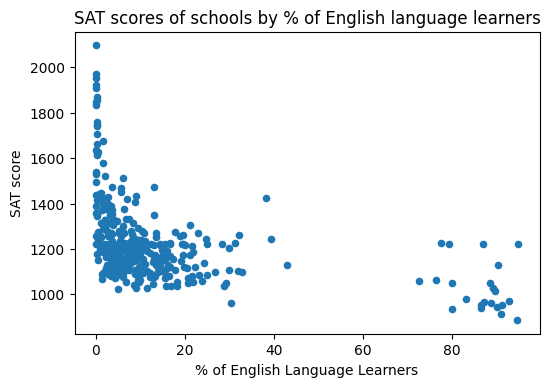

In [326]:
ax = combined.plot.scatter(x='ell_percent', y='sat_score')
ax.set_xlabel('% of English Language Learners')
ax.set_ylabel('SAT score')
ax.set_title('SAT scores of schools by % of English language learners')
plt.show()

### Plotting survey correlations

In [327]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

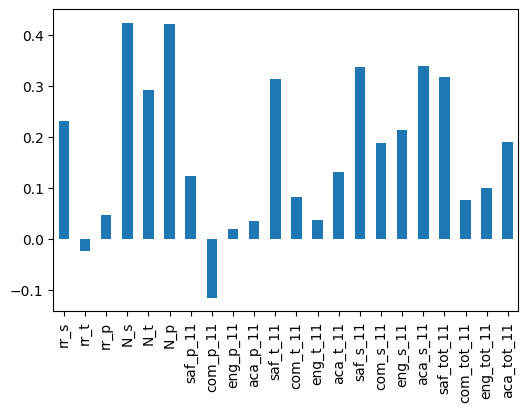

In [328]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

### Exploring safety

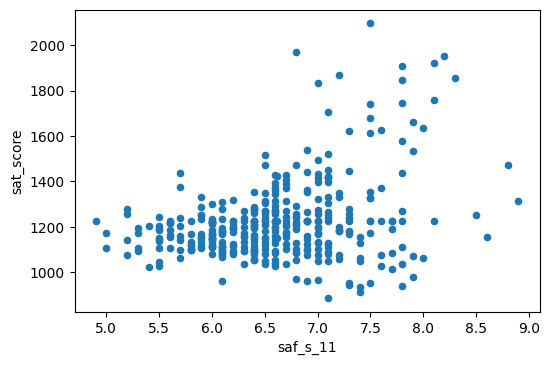

In [329]:
combined.plot.scatter("saf_s_11", "sat_score")

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

### Borough safety

In [330]:
boros = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

### Racial differences in SAT scores

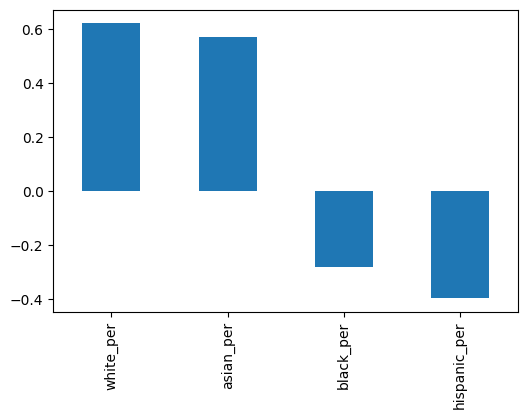

In [331]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

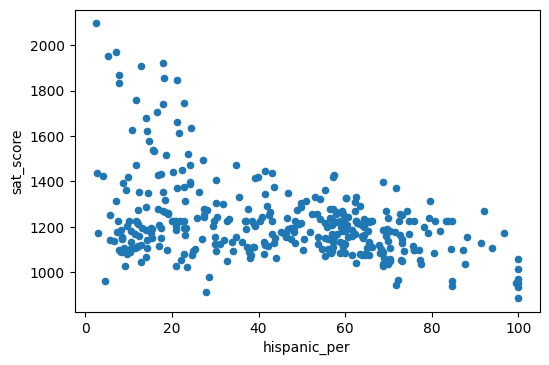

In [332]:
combined.plot.scatter("hispanic_per", "sat_score")

In [333]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [334]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

### Gender differences in SAT scores

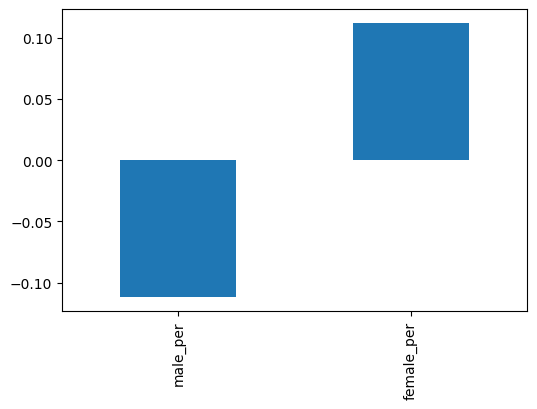

In [335]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

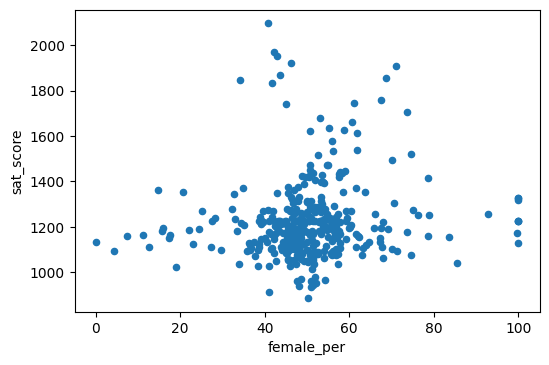

In [336]:
combined.plot.scatter("female_per", "sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [337]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

### AP Exam Scores vs SAT Scores

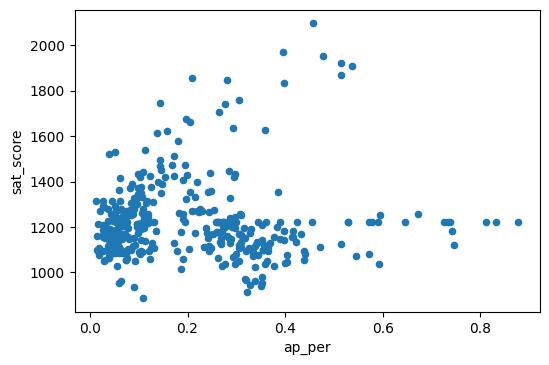

In [338]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.